## WaveRNN

waveRNN使用三种先进的计算方法来提高生成语音的质量。它的模型很小。

论文有三个创新点。

1. 本文提出了一种单层RNN网络架构，使用dual softmax layer去达到目前最好的语音生成水平，可以实时生成 24kHz,16-bit语音。

2. 本文使用权重剪枝技术实现96%的稀疏度。

3. 本文提出了一种高度并行化的语音生成算法。在语音生成中，生成一个很长的序列并将其折叠成几个短序列，这几个短序列都是同时生成的，因此提高生成长序列的速度(将长序列折叠成一批较短的序列，并允许一次生成多个样本)

下面将一一介绍每个创新点。首先分析语音生成的效率，然后根据语音效率的分析，本文一一提出了优化。

### 语音生成效率分析

对于序列生成模型，其生成速度可以用下式来表示。

$$T(u)=|u|\sum_{i=1}^N(c(op_i)+d(op_i))$$

$T(u)$ 是生成某个句子u 发音所需的时间。总共有|u| 个样本，这里的样本和数字音频中的样本是一个意思。对于高质量的声音|u|是非常大的。例如，高保真声音是24k个样本，每个样本对应16bits. N表示神经网络的层数。如果网络有很多层，则N可能非常大。$c(op)$ 代表每一层计算的时间。如果网络很宽或有很多kernels，那么计算时间就会很长。$d(op)$ 表示硬件执行程序的开销时间，包括调用程序和提取相应参数的时间。为了快速生成语音，上述每个参数都应尽可能小。

上面的式子为我们提升效率提供了线索，我们可以通过：(1)降低模型的计算数量(减少N)，(2)选择更适合GPU计算的operation(减少d)，(3)减少权重数量(减少c)，(4)同时生成多个token(减少序列长度)等方法来减少计算时间。

### WaveRNN architecture

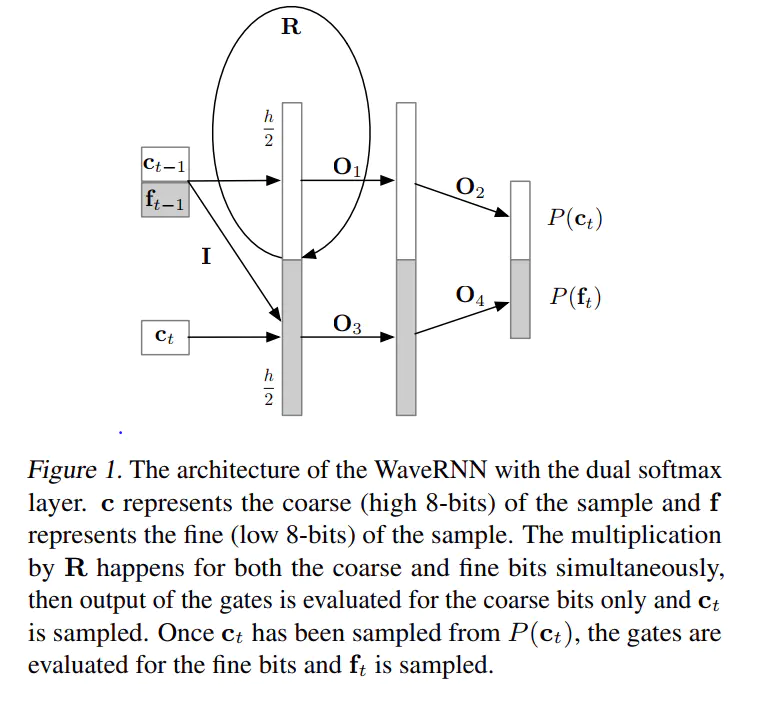

WaveRNN有两个softmax layer. Coarse 8 represents rough 8bit. 可以理解为最重要的8 bits(8 MSB).R层是一个GRU层，会先用来生成coarse 8 bits(粗8bits),生成粗8bits后作为输入生成 fine 8 bits(细8bits)

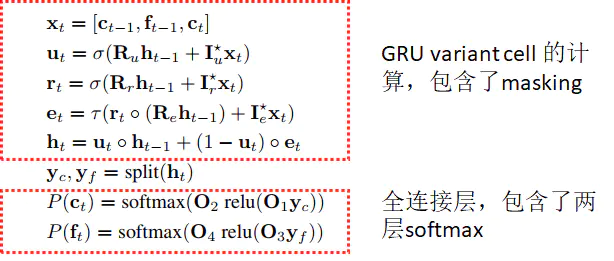

我们先看一下公式，如上图所示 $c_{t-1}$, $f_{t-1}$分别表示t-1时coarse 8bits和fine 8 bits的输出。注意上图的softmax计算可以知道网络的输出是 $c_t$,$f_t$. 计算 $u_t$时有个*，用来表示掩码矩阵。掩码矩阵主要用于计算粗8bits，因为 $x_t$ 的输入中有一个 $c_t$,还没有生成，所以需要使用掩码矩阵把这部分设为0来计算。其中粗细部分均在[0,255]之间，对应softmax 的 256个类型。粗细部分放一起就是对应声音的16bits.

由于我们要生成16bit sequence，因此每个token都要生成16个bit，但是如果直接使用softmax则会有2^16个标签，因此作者把16bit分成两个部分，coarse和fine，即公式中的c和f，coarse是high 8-bit，fine是low 8-bit，这样就把输出空间缩小到2^8=256个值上。

如果你还是不懂这两个阶段的生成过程，下图详细讲解。

粗8bits生成的示意图：

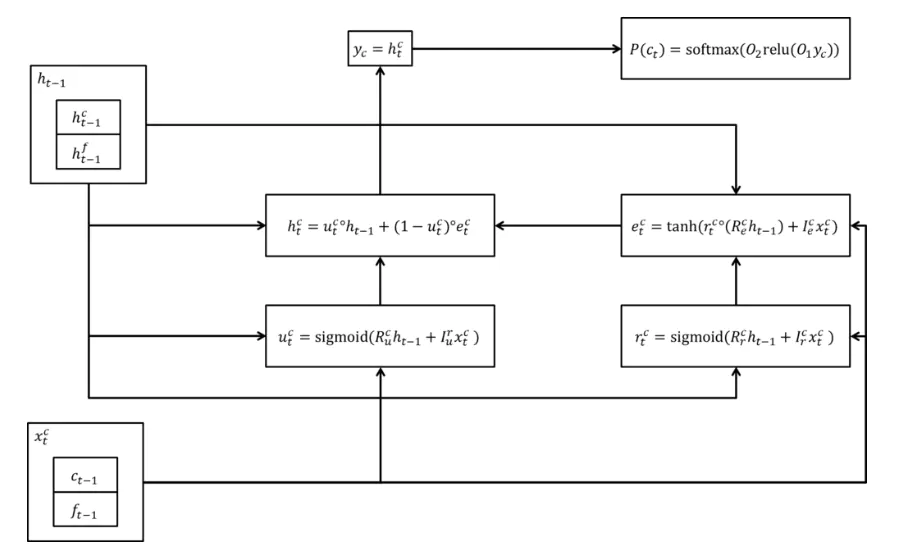

细8bits生成的示意图：

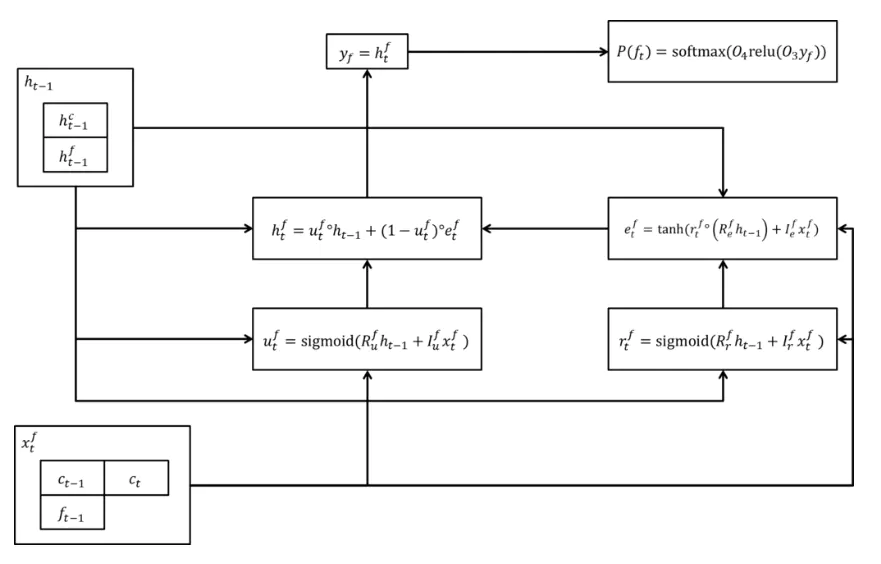

这里的计算对应语音生成效率的分析，也就是减小N的大小，上述模型把N在WaveNet中的30减到了5，生成速度可能比WaveNet快，因为WaveRNN有一个更大的N。

另一个需要考虑的问题是，如何减少参数的装载时间？

作者针对它所进行实验的GPU型号(P100)设计了hidden units的个数896，使得所有参数都可以load到GPU的寄存器中，从而大幅度减少了overhead 时间(d)，模型的速度达到了96000 samples/second。

### Sparse WaveRNN 

#### 1. Weight Sparsification Method

网络的稀疏算法有很多，本文的算法应该不是WaveRNN第一个提出的。WaveRNN使用clip方法。在训练过程中，网络中较小的值被裁剪为0.作者使用了一种随着训练进行逐渐增加稀疏程度的方法。对每个参数矩阵维护一个binary mask，开始的时候binary mask为全1，训练每进行一段时间，就对参数矩阵的元素进行排序，然后把值最小的k个元素的mask设置为0。这个k是根据稀疏性要求来确定的。他会逐渐变大，直到满足稀疏性的要求。

k的计算需要考虑我们想要的稀疏度Z和矩阵中元素的总量，我们计算一个比例z，这个z乘上参数总量就是k的值，z的计算公式如下：

$$z=Z\Big(1-\big(1-\frac{t-t_0}{S}\big)^3\Big)$$

#### 2. Structured Sparsity

我们还可以通过编码稀疏矩阵的方法来减少参数的存储消耗。

作者使用4x4 block作为单位来压缩矩阵，也就是说，原有的参数矩阵被压缩为多个4x4矩阵，这样binary mask的大小就可以缩小为原来的十六分之一，且不会损失表现。作者尝试的另一个结构是16x1 block，这种压缩方法只需要一个dot product就可以得到activation value，因此在效率上表现更好

### Subscale WaveRNN

下图为sub-scale生成过程。

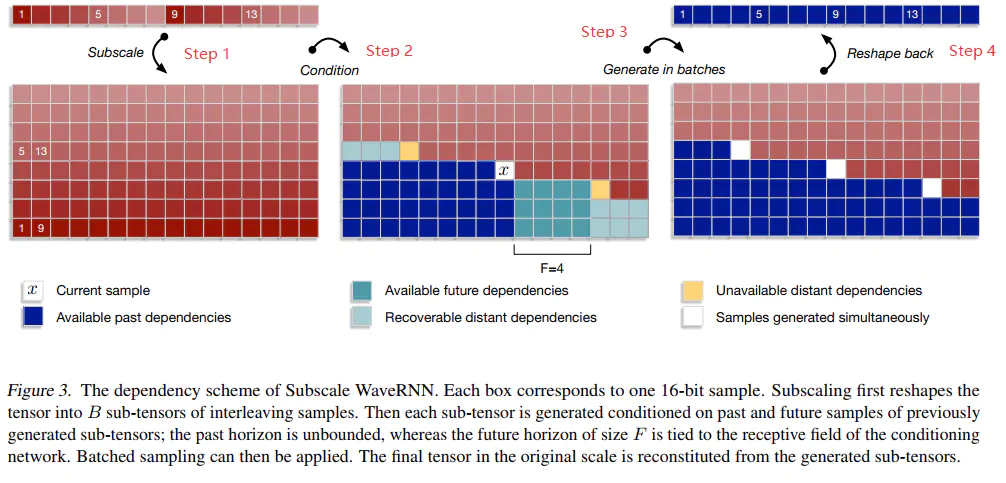

下图为解释sub-scale生成过程，横轴为时间轴

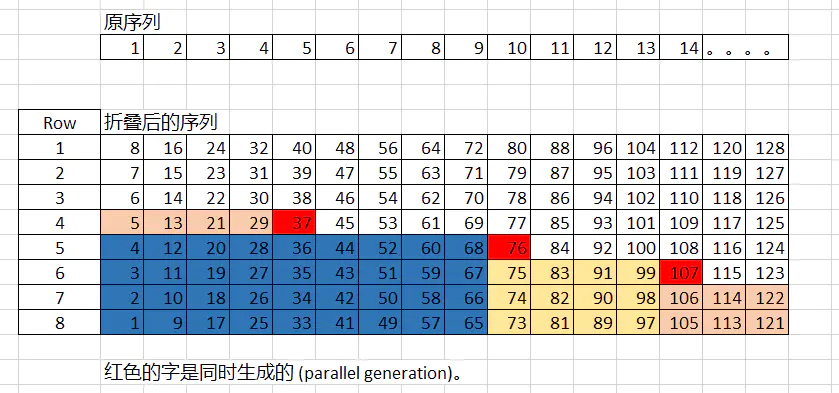

上面介绍的WaveRNN减少了N和 $d(op)$ 的大小，稀疏WaveRNN减少了 $c(op)$ 的计算量，最终减少了 $|u|$ 的大小。一种比较简单的方法是产生8bit量化的声音，但是这种声音的保真度损失很大。本文提出了sub-scale生成过程，可以通过并行线性减少生成声音所需时间，可以用一下公式表示。

$$T(u)=\frac{|u|}{B}\sum_{i=1}^N (c(op_i)^B+d(op_i)^B)$$

其中B是batch_size.当然，这并不代表时间就缩短了B倍，因为该生成的还是要生成，但是同时生成多个token可以重复利用参数，因此还是加快了速度。

这种parallel generation面临的问题就是如何切断token之间的依赖。

我们首先列出同时生成B个token时的序列的概率依赖公式:

$$P(u)=\prod_{s=0}^B \prod_{i=0}^{|u|/B} P(u_{Bi+s}|u_{Bj+s} \text{for} j<i,u_{Bk+z} \text{for} z<s \text{and} k\geq 0)$$

我们看到这个生成不是按照先后顺序生成的，前面的token也会依赖后面的token，但是作者认为，前面的token不会依赖太后面的token，即如果k > i + F，则这个依赖就没什么作用了，因此作者消除了这些依赖。

- step1: 首先将L大小的张量折叠成大小为L/B 的B个张量。
    以上图为例，原序列 1,2,...,128,折叠分成8份，每份16个长度的张量，但是折叠后得到的数组是1,9,17,25，相当于对原始序列进行了下采样，即sub-scale sampling.
    
- step2: 解释声音的产生过程和相关条件（conditions）。假设每个sub-tensor的生成需要较少的前瞻性。用上图解释，第一个生成的行是第八行，即1，9，17，25，33...数组列表。会先生成这一列数组，然后再生成第七行数组，依次生成。但是数组第七行的生成不仅要考虑当时已经生成的第八行和第七行，还要考虑未来横轴上第八行的生成。根据原论文，这里主要对第五行红色数字76的生成做解释。76的生成需要考虑当前时刻之前的所有数字，即第八行第七行第六行第五行，第1-9列蓝色标记的值，以及未来第10-13列。该值，即前瞻性是F=4.

- step3: 解释并行生成的过程。根据上图，红色标记的37,76,107可以同时并行生成。就像step2一样，前瞻性F=4.

- step4: 最后一步是将生成的矩阵展开成原来的序列，1,2,3...这样就达到了高度并行和快速语音生成的目的。
    根据上图的解释，如果要产生24kHz的声音，，如果B=16，则sub-scale生成速度为 24/16=1.5kHz.
    
模型复现：https://github.com/fatchord/WaveRNN